In [1]:
from dataset import Dataset
import torch
from torch import nn 
import torch.optim as optim
from torch.utils import data
import time
from config import Config

In [2]:
train_root = Config.web_root
train_list = Config.AE_train_list
device = torch.device("cuda:3")

In [3]:
train_dataset = Dataset(train_root, train_list, phase='train', input_shape=(1,128,128))
dataset1, dataset2, dataset3, dataset4, dataset5 = data.random_split(
    train_dataset, [10000, 10000, 10000, 10000, 10000])

In [4]:
class EnDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.Encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            nn.GELU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(16, 2*16, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            nn.GELU(),
            nn.Conv2d(2*16, 2*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(2*16, 3*16, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            nn.GELU(),
            nn.Conv2d(3*16, 3*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(3*16, 4*16, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            nn.GELU(),
            nn.Conv2d(4*16, 4*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(4*16, 5*16, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            nn.GELU(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(5*16*16, 512) # 特征向量压缩到384维
        )
        
        self.linear = nn.Sequential(
            nn.Linear(512, 5*16*16),
            nn.GELU()
        )

        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(5*16, 4*16, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            nn.GELU(),
            nn.Conv2d(4*16, 4*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(4*16, 3*16, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            nn.GELU(),
            nn.Conv2d(3*16, 3*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(3*16, 2*16, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            nn.GELU(),
            nn.Conv2d(2*16, 2*16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(2*16, 16, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            nn.GELU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.Encoder(x)
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.Decoder(x)
        return x

In [23]:
model = EnDecoder()
criterion = nn.MSELoss(reduction="none")
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = model.to(device)
criterion = criterion.to(device)
trainloader = data.DataLoader(dataset5, batch_size=128, shuffle=True)

In [24]:
N_epoch = 500
for epoch in range(N_epoch):
    print("epoch = %d in %d" % (epoch, N_epoch))
    time_start = time.process_time()
    
    for x, _ in trainloader:
        x = x.to(device)
        x_ = model(x)
        loss = criterion(x, x_)
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Time elapsed = ", time.process_time()-time_start)
    print("Loss = ", loss.item())

epoch = 0 in 500
Time elapsed =  9.302223004000552
Loss =  1435.501953125
epoch = 1 in 500
Time elapsed =  9.119677725000656
Loss =  1111.419677734375
epoch = 2 in 500
Time elapsed =  9.161460630000875
Loss =  1020.1800537109375
epoch = 3 in 500
Time elapsed =  9.116810903999067
Loss =  1008.565185546875
epoch = 4 in 500
Time elapsed =  9.17378319099953
Loss =  714.6340942382812
epoch = 5 in 500
Time elapsed =  9.126934328000061
Loss =  665.3883056640625
epoch = 6 in 500
Time elapsed =  9.105558578001364
Loss =  866.9535522460938
epoch = 7 in 500
Time elapsed =  9.099235469999257
Loss =  468.9459228515625
epoch = 8 in 500
Time elapsed =  9.103120271998705
Loss =  535.9747314453125
epoch = 9 in 500
Time elapsed =  9.110857326000769
Loss =  611.9549560546875
epoch = 10 in 500
Time elapsed =  9.112977278000471
Loss =  482.9393310546875
epoch = 11 in 500
Time elapsed =  9.133744857999773
Loss =  490.37060546875
epoch = 12 in 500
Time elapsed =  9.085564331000569
Loss =  412.3490905761719
e

In [25]:
AE_path = "AEs/bAE5.pt"
torch.save(model.state_dict(), AE_path)

In [26]:
testmodel = EnDecoder()
testmodel.load_state_dict(torch.load(AE_path))

<All keys matched successfully>

In [27]:
import torchvision
import matplotlib.pyplot as plt

def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.to(device)
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

def get_train_images(num):
    return torch.stack([train_dataset[700+i][0] for i in range(num)], dim=0)

torch.Size([4, 1, 128, 128])


/home/zhuomengzhang/.conda/envs/torch_p36/lib/python3.6/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


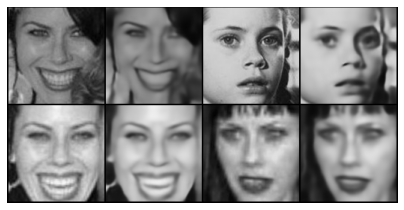

In [28]:
input_imgs = get_train_images(4)
print(input_imgs.shape)
visualize_reconstructions(testmodel, input_imgs)